In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt

In [2]:
data = pd.read_csv('/Users/liuyichen/Desktop/fma4200/project/sorted_final_transactions_dataset.csv')
data['date_BUY_fix'] = pd.to_datetime(data['date_BUY_fix'])
data['date_SELL_fix'] = pd.to_datetime(data['date_SELL_fix'])
grouped = data.groupby('company')

In [3]:
### Denoising by wavelet transform
def wavelet_transform(data):
    # Perform a single-level Discrete Wavelet Transform
    ca, cd = pywt.dwt(data, "haar")
    
    # Apply thresholding to the coefficients
    ca_threshold = np.std(ca)
    cd_threshold = np.std(cd)
    cat = pywt.threshold(ca, ca_threshold, mode="soft")
    cdt = pywt.threshold(cd, cd_threshold, mode="soft")
    
    # Inverse Discrete Wavelet Transform to reconstruct the data
    denoised_data = pywt.idwt(cat, cdt, "haar")
    
    # Adjust the length of denoised_data to match the original data length
    if len(denoised_data) > len(data):
        denoised_data = denoised_data[:len(data)]  # Trim the excess
    elif len(denoised_data) < len(data):
        # Pad with the last value to match the length
        padding = np.full(len(data) - len(denoised_data), denoised_data[-1])
        denoised_data = np.concatenate((denoised_data, padding))
    
    return denoised_data

In [4]:
stable_data = []

unique_grouped = data.groupby(['company', 'date_BUY_fix']).first().reset_index()

for company, group in unique_grouped.groupby('company'):
    group['price_BUY'] = wavelet_transform(group['price_BUY'])
    group['Volatility_Buy'] = wavelet_transform(group['Volatility_Buy'])
    group['Sharpe.Ratio'] = wavelet_transform(group['Sharpe.Ratio'])

    stable_data.append(group)

stable_data_df = pd.concat(stable_data)

# Merge stable_data_df back into the original dataset, updating only specific columns
data = data.merge(stable_data_df[['company', 'date_BUY_fix', 'price_BUY', 'Volatility_Buy', 'Sharpe.Ratio']],
                    on=['company', 'date_BUY_fix'], 
                    suffixes=('', '_updated'))

# Update the corresponding columns in the original dataset with the merged data
data['price_BUY'] = data['price_BUY_updated']
data['Volatility_Buy'] = data['Volatility_Buy_updated']
data['Sharpe.Ratio'] = data['Sharpe.Ratio_updated']

data.drop(['price_BUY_updated', 'Volatility_Buy_updated', 'Sharpe.Ratio_updated'], axis=1, inplace=True)

In [5]:
data

,company,sector,horizon..days.,amount,date_BUY_fix,date_SELL_fix,price_BUY,price_SELL,Volatility_Buy,Volatility_sell,...,investment,ESG_ranking,PE_ratio,EPS_ratio,PS_ratio,PB_ratio,NetProfitMargin_ratio,current_ratio,roa_ratio,roe_ratio
0,1,5,15,20000,2013-10-10,2013-10-25,6.271766,16.661591,0.287138,0.317022,...,1,16.5,10.67,1.42,2.32,3.08,21.67,1.68,18.57,29.06
1,1,5,30,200,2013-10-10,2013-11-08,6.271766,16.586802,0.287138,0.311869,...,1,16.5,10.67,1.42,2.32,3.08,21.67,1.68,18.57,29.06
2,1,5,40,2000,2013-10-10,2013-11-19,6.271766,16.554625,0.287138,0.303038,...,1,16.5,10.67,1.42,2.32,3.08,21.67,1.68,18.57,29.06
3,1,5,4,5000,2013-10-11,2013-10-15,6.271766,15.797400,0.287138,0.322893,...,1,16.5,10.67,1.42,2.32,3.08,21.67,1.68,18.57,29.06
4,1,5,6,200,2013-10-11,2013-10-17,6.271766,15.981767,0.287138,0.322894,...,1,16.5,10.67,1.42,2.32,3.08,21.67,1.68,18.57,29.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405253,27,4,180,300,2018-10-09,2019-04-08,82.369961,96.178032,0.205050,0.195426,...,1,27.3,55.25,1.74,0.56,3.52,1.01,0.81,2.45,6.60
405254,27,4,270,1000,2018-10-09,2019-07-05,82.369961,109.112450,0.205050,0.186011,...,1,27.3,55.25,1.74,0.56,3.52,1.01,0.81,2.45,6.60
405255,27,4,300,3000,2018-10-09,2019-08-05,82.369961,103.110184,0.205050,0.188559,...,1,27.3,55.25,1.74,0.56,3.52,1.01,0.81,2.45,6.60
405256,27,4,360,4000,2018-10-09,2019-10-04,82.369961,115.700928,0.205050,0.178759,...,1,27.3,55.25,1.74,0.56,3.52,1.01,0.81,2.45,6.60


In [11]:
grouped = data.groupby('company')

### Determine whether the time series is stationary
from statsmodels.tsa.stattools import adfuller

# Unit root test (ADF)
def adf_test(data):
    result = adfuller(data)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])


for company, group in grouped:
    print(f"Company: {company}")
    
    variables = ['Sharpe.Ratio', 'price_BUY']
    for variable in variables:
        print(f"Variable: {variable}")
        adf_test(group[variable])
        print()

Company: 1
Variable: Sharpe.Ratio
ADF Statistic: -2.8327978513595182
p-value: 0.05373939865370049

Variable: price_BUY
ADF Statistic: 0.6831318224508172
p-value: 0.9894951540957589

Company: 2
Variable: Sharpe.Ratio
ADF Statistic: -0.8046746026718491
p-value: 0.8177450803971127

Variable: price_BUY
ADF Statistic: 1.9508657332153765
p-value: 0.9986056012239612

Company: 3
Variable: Sharpe.Ratio
ADF Statistic: -1.210419064862644
p-value: 0.6690977106522967

Variable: price_BUY
ADF Statistic: -0.35260797379844366
p-value: 0.9177159268116951

Company: 4
Variable: Sharpe.Ratio
ADF Statistic: -0.856133211066484
p-value: 0.8020750806566536

Variable: price_BUY
ADF Statistic: -0.22880542278287255
p-value: 0.9349998506277885

Company: 5
Variable: Sharpe.Ratio
ADF Statistic: -1.8070922000270264
p-value: 0.37694634153347417

Variable: price_BUY
ADF Statistic: -0.11605591327321102
p-value: 0.9478156335027961

Company: 6
Variable: Sharpe.Ratio
ADF Statistic: -1.1090879984295732
p-value: 0.711434142

In [6]:
data.to_csv('/Users/liuyichen/Desktop/fma4200/project/denoised_final_transactions_dataset.csv', index=False)

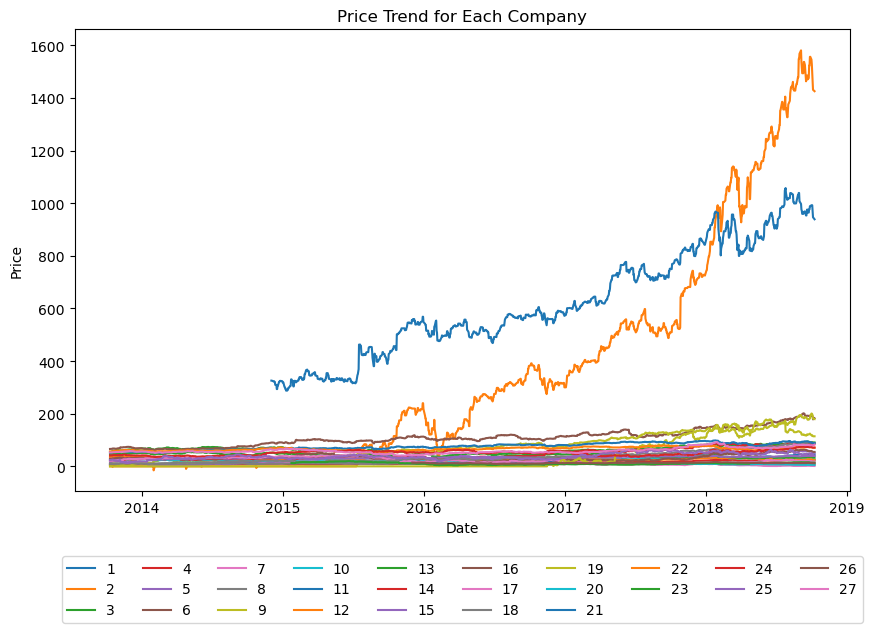

In [8]:
grouped = data.groupby('company')
fig, ax = plt.subplots(figsize=(10, 6))

for company, group in grouped:
    ax.plot(group['date_BUY_fix'], group['price_BUY'], label=company)

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Trend for Each Company')
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=10)

plt.show()